# Graph-Sparse Logistic Regression applied to the real proteomics data from the TCGA/CPTAC Breast Cancer dataset. 

In [1]:
%pylab inline

import sys
import pickle
import pandas as pd
import networkx as nx

from sklearn.preprocessing import LabelEncoder

from matplotlib_venn import venn3, venn3_circles, venn2

repo_path = '/Users/alex/Documents/gslr/'
interactome_path = repo_path + 'experiments/algorithms/pcsf/inbiomap_temp.tsv'

sys.path.append(repo_path + 'gslr/')
import gslr

Populating the interactive namespace from numpy and matplotlib


### i. Load Datasets

In [2]:
# medullo = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/medullo_inbiomap_exp.tsv', index_col=0)
# ovarian = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/ovarian_inbiomap_exp.tsv', index_col=0)
brca = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/brca_inbiomap_exp.tsv', index_col=0)

# medullo_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/medullo_labels.csv', index_col=0)
# ovarian_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/ovarian_labels.csv', index_col=0)
brca_labels = pd.read_csv('/Users/alex/Documents/proteomics/data_preparation/proteomics_data/raw/brca_labels.csv', index_col=0)

### ii. Load Interactome

In [3]:
inbiomap_experimentally = pd.read_csv(interactome_path, sep='\t', names=['protein1','protein2','cost'])
inbiomap_experimentally.head()

,protein1,protein2,cost
0,ZNF91,NDEL1,1.253
1,ZNF91,ELAVL1,1.254
2,ZNF91,SUMO1,1.245
3,ZNF91,SUMO3,1.245
4,ZNF91,CHMP5,1.241


In [4]:
(edges, nodes) = pd.factorize(inbiomap_experimentally[["protein1","protein2"]].unstack())
edges = edges.reshape(inbiomap_experimentally[["protein1","protein2"]].shape, order='F')
edges

array([[    0,  1228],
       [    0,  1279],
       [    0,  4071],
       ..., 
       [14190, 14237],
       [14191, 14378],
       [14192, 14539]])

In [12]:
dataset = brca.copy()
labels = brca_labels.loc['PAM50 mRNA']
dataset.shape, labels.shape

((111, 16349), (111,))

### i. Prepare Dataset

In [7]:
dataset = dataset.transpose().reindex(index=nodes).transpose()
X = dataset.values
dataset.head()

,ZNF91,ACP5,SLC27A2,PAX9,ADAM15,ELOVL2,DDX60L,FGF7,CDHR5,LYPD3,...,CNR2,GIG44,LINC00588,TAAR2,CHRNE,ANKAR,DHH,CYSLTR1,COL23A1,MEDAG
AO-A12D.01TCGA,-1.102122,-0.747811,-3.292756,1.976195,2.341935,0.0,0.086535,0.0,0.0,0.280834,...,0.0,0.0,0.0,0.0,-1.513581,0.000000,0.0,0.0,0.000000,0.0
C8-A131.01TCGA,-0.644553,1.496776,-2.061312,2.496602,1.589877,0.0,-0.531213,0.0,0.0,-0.660745,...,0.0,0.0,0.0,0.0,0.112400,0.000000,0.0,0.0,0.000000,0.0
AO-A12B.01TCGA,1.274661,1.055714,0.634450,-1.333296,-0.335566,0.0,1.116687,0.0,0.0,-0.044561,...,0.0,0.0,0.0,0.0,-0.604399,0.000000,0.0,0.0,0.000000,0.0
E2-A10A.02TCGA,-9.048165,1.054283,0.867457,0.000000,-0.089739,0.0,0.975862,0.0,0.0,-0.315775,...,0.0,0.0,0.0,0.0,-4.458240,0.180121,0.0,0.0,-5.390064,0.0
BH-A18Q.02TCGA,-3.728792,1.302662,-2.554563,0.000000,-0.470390,0.0,0.332501,0.0,0.0,-1.979158,...,0.0,0.0,0.0,0.0,-3.524724,-0.998961,0.0,0.0,-1.310081,0.0


In [13]:
labels = labels.values.flatten().tolist()

In [14]:
labeler = LabelEncoder()
labeler.fit(labels)
y = labeler.transform(labels)
y

array([1, 0, 3, 3, 0, 1, 1, 2, 3, 3, 1, 2, 1, 2, 0, 0, 2, 1, 3, 1, 0, 3, 2,
       1, 3, 0, 2, 1, 2, 0, 2, 3, 0, 0, 3, 2, 0, 3, 2, 3, 2, 1, 3, 1, 2, 1,
       2, 3, 2, 3, 1, 2, 3, 0, 0, 2, 3, 3, 1, 2, 1, 0, 3, 3, 0, 2, 2, 1, 3,
       0, 3, 2, 2, 3, 1, 2, 3, 1, 3, 0, 2, 2, 3, 0, 2, 0, 3, 3, 0, 3, 0, 3,
       2, 1, 0, 0, 2, 3, 2, 3, 0, 3, 3, 0, 2, 0, 3, 0, 4, 4, 4])

### ii. Graph-Sparse Logistic Regression

In [15]:
d = len(nodes)
c = 5

graph_opts = gslr.GraphOptions(edges=edges, root=-1, num_clusters=1, pruning='strong')

sparsity_low = 150
sparsity_high = 350

verbosity_level = 1

num_steps = 25
possible_steps = np.array([0.03, 0.1, 0.3])
steps = np.tile(possible_steps, (num_steps, 1))

W0 = np.zeros((c, d))

In [17]:
W_hat, losses = gslr.gslr(X, y, W0, sparsity_low, sparsity_high, graph_opts, steps, verbosity_level, edge_costs=inbiomap_experimentally.cost.values, edge_costs_multiplier=2)

iteration 1:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289145745312761   step_size = 0.1
  loss_cur = 1.6094379124340985   loss_next = 16.934794370801768   step_size = 0.3
  best_step_size: 0.0
iteration 2:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289145745312761   step_size = 0.1
  loss_cur = 1.6094379124340985   loss_next = 16.934794370801768   step_size = 0.3
  best_step_size: 0.0
iteration 3:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289145745312761   step_size = 0.1
  loss_cur = 1.6094379124340985   loss_next = 16.934794370801768   step_size = 0.3
  best_step_size: 0.0
iteration 4:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289

iteration 14:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289145745312761   step_size = 0.1
  loss_cur = 1.6094379124340985   loss_next = 16.934794370801768   step_size = 0.3
  best_step_size: 0.0
iteration 15:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289145745312761   step_size = 0.1
  loss_cur = 1.6094379124340985   loss_next = 16.934794370801768   step_size = 0.3
  best_step_size: 0.0
iteration 16:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5.289145745312761   step_size = 0.1
  loss_cur = 1.6094379124340985   loss_next = 16.934794370801768   step_size = 0.3
  best_step_size: 0.0
iteration 17:
  loss_cur = 1.6094379124340985   loss_next = 1.8155318506232232   step_size = 0.03
  loss_cur = 1.6094379124340985   loss_next = 5

Train accuracy: 0.23423423423423423


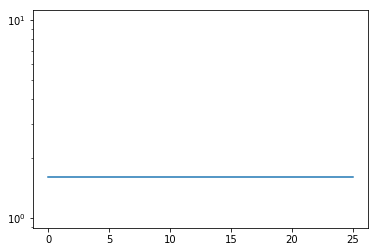

In [18]:
yhat = gslr.predict(X, W_hat)
num_cor = gslr.num_correct(y, yhat)
print('Train accuracy: {}'.format(num_cor / float(len(y))))

plt.plot(losses)
plt.yscale('log')

### iii. Unpack Results

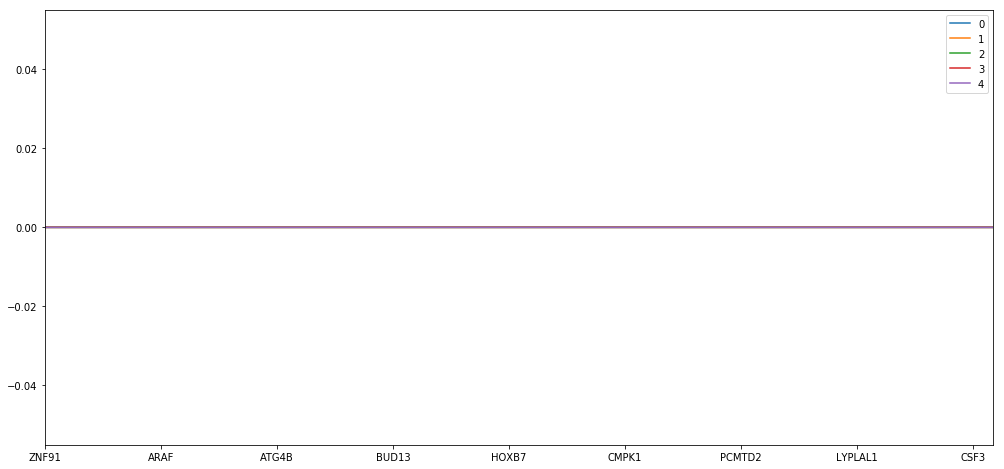

In [19]:
coefs = pd.DataFrame(W_hat, columns=dataset.columns)
coefs.transpose().plot(figsize=(17,8))

In [20]:
features = coefs.columns[(coefs != 0).any()].tolist()
len(features)

0

In [21]:
features

[]

In [17]:
coefs.to_pickle('brca_coefs.pickle')